In [2]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms
data_path = '../C7'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [7]:
# nn.Conv1d = for time series
# nn.Conv2d = for images
# nn.Conv3d = for volumes or videos

In [8]:
# Example of conv

conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # channels, number of output features, size of kernel aka filter
conv, conv.weight.shape, conv.bias.shape
# weight shape = outputs x channels x filtersize (padding doesn't change weight shape)

(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 torch.Size([16, 3, 3, 3]),
 torch.Size([16]))

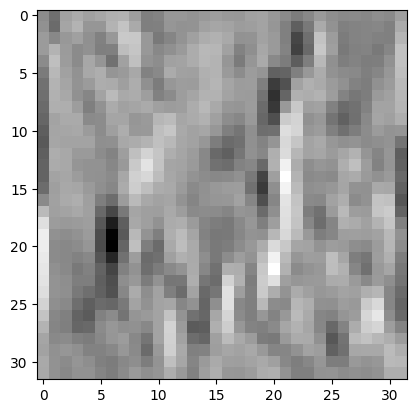

In [9]:
# Vertical edge detection filter/kernel example

conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()


In [10]:
# Maxpool example

pool = nn.MaxPool2d(2) # choses max from 2x2 tiles
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

When the second 3 × 3 convolution kernel produces 21 in its conv output in figure
8.8, this is based on the top-left 3 × 3 pixels of the first max pool output. They, in turn,
correspond to the 6 × 6 pixels in the top-left corner in the first conv output, which in
turn are computed by the first convolution from the top-left 7 × 7 pixels. So the pixel
in the second convolution output is influenced by a 7 × 7 input square. The first
convolution also uses an implicitly “padded” column and row to produce the output in
the corner; otherwise, we would have an 8 × 8 square of input pixels informing a given
pixel (away from the boundary) in the second convolution’s output. In fancy language,
we say that a given output neuron of the 3 × 3-conv, 2 × 2-max-pool, 3 × 3-conv
construction has a receptive field of 8 × 8

### When moving from conv layers -> FC layers...
##### What’s missing there is the reshaping step from an 8-channel 8 × 8 image to a 512-element, 1D vector (1D if we ignore the batch dimension, that is). This could be achieved by calling view on the output of the last nn.MaxPool2d, but unfortunately, we don’t have any explicit visibility of the output of each module when we use nn.Sequential.

### Solution...

##### At some point in developing neural networks, we will find ourselves in a situation where we want to compute something that the premade modules do not cover. Here, it is something very simple like reshaping. When we want to build models that do more complex things than just applying one layer after another, we need to leave nn.Sequential for something that gives us added flexibility. PyTorch allows us to use any computation in our model by subclassing nn.Module.

In [11]:
# Again: When going from conv layer to FC layer that output is not defined in sequential layer for each layer 
# so this causes problem for change in 3d -> 1d. Hence another module is created that accounts the output for 
# each layer

# This solution can be used for many problems. Here this could also be solved by:

flatten = nn.Flatten()

In [12]:
# define constructor __init__
# assign self to forward function
# Forward function will hold the parameters throughout the lifetime of module
# To hold these parameters remember to super().__init__()

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [13]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [14]:
# To make this more concise we use functional

# By “functional” here we mean “having no internal state”—in other words, “whose output value is solely 
# and fully determined by the value input arguments unlike nn which works on input arguments and stored parameters.” 

# We can safely switch to the functional counterparts of pooling and activation, since they have no parameters

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # to hold the parameters 
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
# When we are writing our own forwards, it may be more natural to
# use the functional interface for things that do not need state in the form of parameters.

In [15]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0604, -0.0565]], grad_fn=<AddmmBackward0>)

In [26]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1): # loop starts from 1 to n_epochs+1
        loss_train = 0.0
        for imgs, labels in train_loader: # loops over batches
            outputs = model(imgs) # feeds a batch through model
            loss = loss_fn(outputs, labels) # computes loss
            optimizer.zero_grad() # getting rid of gradients from last round
            loss.backward() # evaluated gradient of parameters
            optimizer.step() # update the model
            loss_train += loss.item() # sums the loses over the epoch. .item() escapes the gradient
        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader))) # divide the lenght to get the average loss per batch
            

In [27]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()

optimizer = optim.SGD(model.parameters(), lr=1e-2)

loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=30,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2024-04-27 15:42:44.607877 Epoch 1, Training loss 0.5775922356517451
2024-04-27 15:42:45.790877 Epoch 2, Training loss 0.49039286716728453
2024-04-27 15:42:48.231877 Epoch 4, Training loss 0.44058112297088475
2024-04-27 15:42:50.648877 Epoch 6, Training loss 0.390806076063472
2024-04-27 15:42:53.080879 Epoch 8, Training loss 0.35277803878116
2024-04-27 15:42:55.537877 Epoch 10, Training loss 0.33541781317656205
2024-04-27 15:42:57.993877 Epoch 12, Training loss 0.32785301679258894
2024-04-27 15:43:00.488877 Epoch 14, Training loss 0.3188092040408189
2024-04-27 15:43:03.038877 Epoch 16, Training loss 0.3127938439701773
2024-04-27 15:43:05.507876 Epoch 18, Training loss 0.3067388805993803
2024-04-27 15:43:08.156877 Epoch 20, Training loss 0.3005283106664184
2024-04-27 15:43:10.906877 Epoch 22, Training loss 0.2950754595600116
2024-04-27 15:43:13.761877 Epoch 24, Training loss 0.28879969676209105
2024-04-27 15:43:16.298878 Epoch 26, Training loss 0.28384472192472715
2024-04-27 15:43:19.00

In [28]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # no use of gradients here
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # index for highest value of output
                total += labels.shape[0]  # increased by batch size
                correct += int((predicted == labels).sum())  # number of true predictions

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.89
Accuracy val: 0.87


In [29]:
# to save the model

# torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

# to load the model 

# loaded_model = Net()
# loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

# Training on GPU

In [30]:
# Move tensors and parameters to the GPU

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [31]:
# Moving tensors

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # Here the image tensors are moved to the GPU
            labels = labels.to(device=device) # Here the labels tensors are moved to the GPU
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # Here the parametes/model is moved to the GPU. .cuda() can also be used if sure there is a graphics card

# Moves our model (all parameters) to the GPU. If you forget to move either the 
# model or the inputs to the GPU, you will get errors about tensors not being on the same 
# device, because the PyTorch operators do not support mixing GPU and CPU inputs.

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-04-27 15:44:18.055684 Epoch 1, Training loss 0.564361229254182
2024-04-27 15:44:20.827684 Epoch 10, Training loss 0.3302257911414857
2024-04-27 15:44:23.885683 Epoch 20, Training loss 0.2985191607171563
2024-04-27 15:44:26.943683 Epoch 30, Training loss 0.2720786065907235


In [33]:
# loaded_model = Net().to(device=device)
# loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

In [34]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [35]:
# Regularization: This term is crafted so that the weights of the model tend to be small on their own, limiting
# how much training makes them grow. In other words, it is a penalty on larger weight values. 

# L2 regularization: Sum of squares of all weight
# L1 regularization: Sum of absolute values of weights

def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # replace pow(2.0) with abs() for L1 regularization
            loss = loss + l2_lambda * l2_norm # added to loss that is backpropagated

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader))) 
            
# SGD already has weight_decay parameter that correspoinds to 2*lambda which can be used

In [37]:
# The idea behind dropout: zero out a random fraction of outputs from neurons across the network,
# where the randomization happens at each training iteration.

# Less chance of coordination in the memorization process

class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
# During evaluation the dropout is bypassed

In [38]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
# if model.eval() is used then normalization layers are forzen

In [39]:
# In regard to computer vision, a shallower network could identify a person’s shape in a photo, 
# whereas a deeper network could identify the person, the face on their top half, and the mouth within the face

In [41]:
# For a large network of more than 20 layers, the backpropagation multiplication can cause generation of small or large uneven number
# Hence resnet was used for skip connections

class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # identity mapping done, creates a direct path from deeper parameters to the loss. This makes the contribution to the gradient more direct
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
# FOR DEEP MODELS: Creating 1 block

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x


In [43]:
# FOR DEEP MODELS: Creating Deep model using many blocks

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out